# NAR Paper Data processing and analysis for complete reproducibility

In this notebook, we provide the necesary information to reproduce the analysis we carried out for the NAR paper. The analsysius complements the methodiology and the results section of our paper. 

More details can be obtained by emailing: calebkibet88[at]gmail.com

### Install the necessary modules

A requirements file is also provided for easy install. We are using the conda environment to get all the dependencies in place, but pip can also be used. The bioinformatics moduls are obtained from the Bioconda Bioinforatics repository in Anaconda. 

#### From conda:
* ipython==4.2.0
* jupyter==1.0.0
* numpy==1.10.4
* pandas==0.17.1
* scipy==0.16.0
* seaborn==0.5.1
* matplotlib==1.4.3

#### From Bioconda
* gimmemotifs==0.8.5
* pybedtools==0.7.6

#### Non-python modules

* meme v4.11.1
* bedtools v2.24.0

### Table of contents

1. [Import dependencies](#import)
2. [Figure 4A: Correlating CB-MAR  with Energy AUC ranking in ChIP-seq data](#figure4a)
3. [Figure 5: Correlating CB-MAR with Energy AUC ranking in PBM data](#figure5)
4. [Figure 6: PBM ChIP-seq Energy AUC scores corelation](#figure6)
5. [Figure 7: Joint scatter plot and histogram for gimme roc and Energy scoring Correlation scores](#figure7)
2. [Figure 8: Comparing performance of top three motifs in Gimme and CB-MAR](#figure8)
2. [Supplementary Figure 1: Gimme motifs and consistency motif ranking comparison.](#figs1)
2. [Run Gimme Roc Analsysis](#gimme_roc)

Just need to upgrade these untill I will have captured all the major headings. A few will have to be  shifted around to ensure the story can flow from the beginning and someone can actually follwo what is going on. 

<a id='import'></a>
### Import all dependencies

In [25]:
##Pure python

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ranksums
from scipy.stats.mstats import winsorize
import scipy.stats
import numpy as np
from math import log
from scipy import stats
#import os moduls
import os

## Bioconda
import pybedtools

%matplotlib inline

### First run tomtom pairwise comparison

We use Jun to demonstrate how we carried out the analsysis and the "Example_data" folder within the working directory. 

In [20]:
tomtom_path = !which tomtom
tomtom_path = tomtom_path[0]
meme_in = "./Example_data/Jun.meme"
results_folder = "Example_data"
tf = "Jun"
os.system(
    "%s -min-overlap 1 -dist %s -evalue -text -thresh 1000 -verbosity 1 %s %s >%s/%s_tomtom.txt" %
          (tomtom_path, "ed", meme_in, meme_in, results_folder, tf))

0

### These utility function will be used for data cleaning and processing

In [21]:
tomtom = pd.read_table("./Example_data/Jun_tomtom.txt")

# To avoid zezo division, use add the smallest possible value to each

tomtom["p-value"] += 0.000000000000000000000000000000000000000000000001

#Get the negative log of the p-value column
tomtom["p-value"] = -tomtom["p-value"].apply(log)

#Exatract the important columns to be used for any further analysis
tomtom = tomtom[["#Query ID", "Target ID", "p-value"]]

#Change the column names
tomtom.columns = [["Query_ID", "Target_ID", "Score"]]

#Pivit the data into a pairwise matrix

tomtom_matrix = tomtom.pivot(index="Query_ID", columns="Target_ID", values="Score")


### Reduce effect of extreme outliers by winzorizing the data

In [28]:
#convert the dataframe to an array the winsorize and finally convert back into a dataframe

tomtom_winz = pd.DataFrame(scipy.stats.mstats.winsorize(np.array(tomtom_matrix.values.T.tolist()),
                                                     limits=0.05), index=tomtom_matrix.index, columns=tomtom_matrix.columns)

### Normalize the data by the maximum value

In [29]:
tomtom_normalized = tomtom_winz.div(tomtom_winz.max())

### Add a new average column to the matrix and sort the mean in ascending order

In [24]:
tomtom_normalized["Average"] = tomtom_normalized.mean()
tomtom_normalized.sort_values(by="Average", ascending=False, inplace=True)
tomtom_normalized.loc["Average"] = tomtom_normalized.mean(axis=0)
tomtom_normalized = tomtom_normalized.T
tomtom_normalized.sort_values(by="Average", axis=0, ascending=False, inplace=True)
tomtom_normalized.drop("Average", axis=0, inplace=True)

### Save the data into a file

In [26]:
tomtom_normalized.to_csv("./Example_data/%s_tomtom_raw.txt" % tf, sep="\t")

### Plot the figures required

/home/kipkurui/anaconda2/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


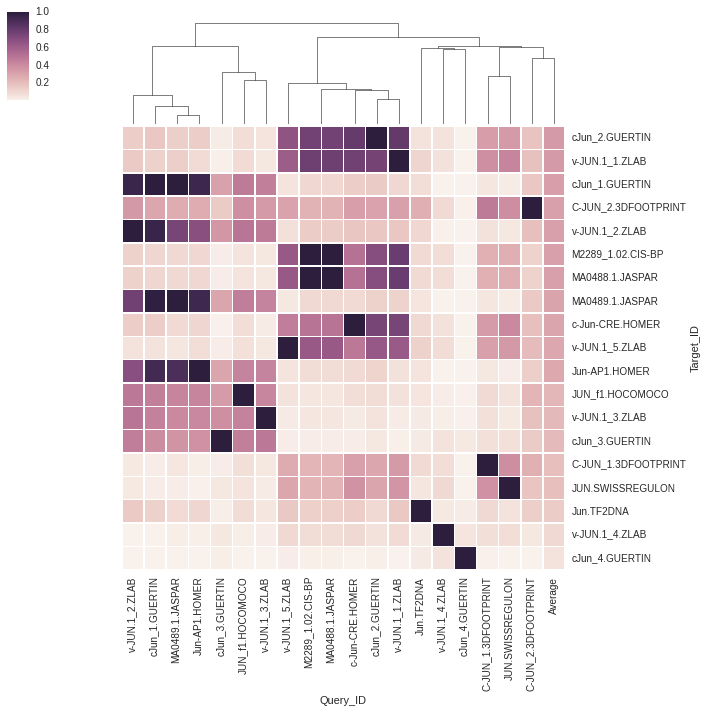

In [27]:
cg = sns.clustermap(tomtom_normalized, method='single', metric="euclidean", row_cluster=False, linewidths=.15)
test = plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
test = plt.setp(cg.ax_heatmap.xaxis.get_majorticklabels(), rotation=90)

#### Run complete analysis by importing run_tomtom module

#### Frist, let get a list of all the transcription factors with data in PBM and ChIP-seq Encode

At the same time, since we are using TF class IDs, we need to create a dictionary that we will use to convert Tf ID them to readable TF name

In [3]:
pbm_chip = []
pbmchip2name = {}
with open('../Data/Pbm_Chip_details.txt') as pbmnchip:
    for line in pbmnchip:
        if line.startswith('Tf_id'):
            continue
        else:
            pbm_chip.append(line.split()[0])
            pbmchip2name[line.split()[0]] = line.split()[1]
            
#TFs with data in PBM and ChIP-se qnd over 10 motifs in DB

pbm_chip_over10 = pd.read_table("../Data/PbmChipOver10.txt").values.T.tolist()[0]
    

#get a list of TFs with chipseq data
chipseq = []
with open('../Data/Chip_details.txt') as chip_det:
    for line in chip_det:
        if line.startswith('Tf_id'):
            continue
        else:
            chipseq.append(line.split()[0])

#narrow down to those with over 10 motifs

"""
This to ensure robust results when using the consistency based approach
and explained in the paper. This was done by querying the database.
Here, we just import the pre-computed list.
"""
over10_chip =[]
for tf in chipseq:
    if tf in pbm_chip_over10:
        over10_chip.append(tf)
        
pbms = []
with open('../Data/passed_pbm_details.txt') as chip_det:
    for line in chip_det:
        if line.startswith('Tf_id'):
            continue
        else:
            pbms.append(line.split()[0])
            
over10_pbm =[]
for tf in pbms:
    if tf in pbm_chip_over10:
        over10_pbm.append(tf)
        
tf_classdisct = {}
with open("../Data/tf_class") as tcf:
    for line in tcf:
        tf_classdisct[line.split()[0]] = line.split()[1]

# Move these to their respective folders

In [69]:

#TODO" I will need to import the run_tomtom module as a standalone for complet analysis
def run_tomtom(tf,meme_in, results_folder):
    os.system(
        "%s/tomtom -min-overlap 1 -dist %s -evalue -text -thresh 1000 -verbosity 1 %s %s >%s/%s_tomtom.txt" %
              (meme_path, "ed", meme_in, meme_in, results_folder, tf))

    clean_tomtom('%s/%s_tomtom.txt' % (results_folder, tf) ,'%s/%s_tomtom_raw.txt' % (results_folder, tf))
    
    #Uncomment below to plot figures. For this anlaysis we did not need them
    
    #plot_tomtom('%s/%s_tomtom_raw.txt' % (results_folder, tf), '%s/%s_tomtom.png' % (results_folder, tf))


def clean_tomtom(tom_in, tom_out):

    tomtom = pd.read_table(tom_in)

    tomtom["p-value"] += 0.000000000000000000000000000000000000000000000001

    tomtom["p-value"] = -tomtom["p-value"].apply(log)

    tomtom = tomtom[["#Query ID", "Target ID", "p-value"]]

    tomtom.columns = [["Query_ID", "Target_ID", "Score"]]

    tomtom_matrix = tomtom.pivot(index="Query_ID", columns="Target_ID", values="Score")
    
    tomtom_winz = pd.DataFrame(
        winsorize(np.array(tomtom_matrix.values.T.tolist()),
                  limits=0.05), index=tomtom_matrix.index, columns=tomtom_matrix.columns)

    # Normalize

    tomtom_normalized = tomtom_winz.div(tomtom_winz.max())
    #Add average column
    tomtom_normalized["Average"] = tomtom_normalized.mean()
    
    #sort by average and ensure the marix shape is retained
    tomtom_normalized.sort_values(by="Average", ascending=False, inplace=True)
    tomtom_normalized.loc["Average"] = tomtom_normalized.mean(axis=0)
    tomtom_normalized = tomtom_normalized.T
    tomtom_normalized.sort_values(by="Average", axis=0, ascending=False, inplace=True)
    tomtom_normalized.drop("Average", axis=0, inplace=True)

    # Save the data to file
    tomtom_normalized.to_csv("%s" % tom_out, sep="\t")

    return tomtom_normalized


def plot_tomtom(tom_in, figure_output):

    tomtom_normalized = pd.read_table(tom_in, index_col="Target_ID")

    cg = sns.clustermap(tomtom_normalized, method='single', metric="euclidean",
                        row_cluster=False, linewidths=.15)
    test = plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
    test = plt.setp(cg.ax_heatmap.xaxis.get_majorticklabels(), rotation=90)

    fig = plt.gcf()
    fig.savefig(figure_output, bbox_inches='tight')


### Run complete Tomtom analysis

Uncomment the cell below to run complete analysis

In [61]:
#Remember this can take a while

# for tf_id in pbm_chip_over10:
#     meme_in = '../Motifs/%s.meme' % tf_id
#     results_path = "../FisimTomtom/%s" % tf_id
#     if os.path.isdir(results_path):
#         pass
#     else:
#         os.makedirs(results_path)

#     run_tomtom(tf_id,meme_in, results_path)

### Run FISim analysis

Below we just demonstrate how this analsysis can be carried out

In [78]:
BASE_DIR = "/home/kipkurui/Project/Motif_Assessment/PAPER_Assessment_Data/NAR_Paper/Code/"

In [82]:
def run_fisim(meme_in, results_folder, tf_name):
    tf_path = "%s/%s" % (results_folder, tf_name)
    os.chdir("/home/kipkurui/Project/MAT_server/MARST_Suite//FISIM")  # May need to rethink the location of the scripts
    os.system("python fisim.py -fileList %s -o %s.fisim -core -ID" % (meme_in, tf_path))
    os.chdir(BASE_DIR)
    #path = '%s/%s/%s' % (results_folder, tf_name, tf_name)
    #utils.plot_heatmap_fisim(path+'.fisim', path+'_fisim.png')
    #utils.plot_heatmap_fisim(path+'.fisim', path+'_fisim.eps')
    
tf_name = "Jun"
meme_in = '%s/Example_data/Jun.meme' % BASE_DIR
results_path = "%s/Example_data" % BASE_DIR
run_fisim(meme_in, results_path, tf_name)

#### For a complete run

Uncomment below for complete run

In [ ]:
# for tf_id in pbm_chip_over10:
#     results_path = "../FisimTomtom/%s" % tf_id
#     if os.path.isdir(results_path):
#         pass
#     else:
#         os.makedirs(results_path)

#     run_tomtom(tf_id,meme_in, results_path)
    

### Lets start with how we process the peak file into fasta

For this we use the PybedTools, but can also be done using the native BedTools. Read the comments in the function below for processing details

#### Lets again demonstrate this using Jun TF

First we download the file from ENCODE

In [14]:
! wget -O ./Example_data/wgEncodeAwgTfbsSydhHelas3CjunIggrabUniPk.narrowPeak.gz http://hgdownload.cse.ucsc.edu/goldenPath/hg19/encodeDCC/wgEncodeAwgTfbsUniform/wgEncodeAwgTfbsSydhHelas3CjunIggrabUniPk.narrowPeak.gz

--2016-07-05 13:07:44--  http://hgdownload.cse.ucsc.edu/goldenPath/hg19/encodeDCC/wgEncodeAwgTfbsUniform/wgEncodeAwgTfbsSydhHelas3CjunIggrabUniPk.narrowPeak.gz
Resolving hgdownload.cse.ucsc.edu (hgdownload.cse.ucsc.edu)... 128.114.119.163
Connecting to hgdownload.cse.ucsc.edu (hgdownload.cse.ucsc.edu)|128.114.119.163|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 540459 (528K) [application/x-gzip]
Saving to: ‘./Example_data/wgEncodeAwgTfbsSydhHelas3CjunIggrabUniPk.narrowPeak.gz’

./Example_data/wgEn 100%[=====================>] 527.79K   105KB/s   in 5.0s   

2016-07-05 13:07:50 (105 KB/s) - ‘./Example_data/wgEncodeAwgTfbsSydhHelas3CjunIggrabUniPk.narrowPeak.gz’ saved [540459/540459]



#### Uncompress the file using gunzip

In [16]:
! gunzip ./Example_data/wgEncodeAwgTfbsSydhHelas3CjunIggrabUniPk.narrowPeak.gz

In [8]:
peak = "./Example_data/wgEncodeAwgTfbsSydhHelas3CjunIggrabUniPk.narrowPeak"
negfa_out = "./Example_data/Jun.fa"

#Expand to 100bp centered on the peak
width = 100

#Extract negative sequences 500bp downstream
downstream_distance = 500


get_fasta_from_bed(peak, negfa_out, width, downstream_distance)

In [21]:
peak = "./Example_data/wgEncodeAwgTfbsSydhHelas3CjunIggrabUniPk.narrowPeak"
#negfa_out = "./Example_data/Jun.fa"
neg_bed = "./Example_data/Jun.negbed"
pos_bed = "./Example_data/Jun.posbed"
#Expand to 100bp centered on the peak
width = 100

#Extract negative sequences 500bp downstream
downstream_distance = 500

get_bed_from_peaks(peak, pos_bed, neg_bed, width, downstream_distance)

### PBM data

PBM data used for motif assessment were downloaded from [UniProbe database](http://thebrain.bwh.harvard.edu/pbms/webworks_pub/downloads.php), We only use the PBM intensity files to determine  assess the perfomnce of a motif. We mainly adopted the defenition of positive and negative sets described by Chen et al 2007. A given motif is used to score a 36bp sequence for each spot using the different scoring function described in the main paper.

In [ ]:
# Import runpbm assess

### Perform Enrichment analysis

Nothing much has actually been done for this section of the analytics

In [ ]:
# def plot_centrimo(centrimo_in, figure_output):
#     centrimo_table = pd.read_table(centrimo_in, index_col=0)
#     centrimo_table.sort(columns="Average", axis=0, ascending=False, inplace=True)
#     sns.clustermap(centrimo_table, method='single', metric="euclidean",
#                    z_score=None, row_cluster=False, col_cluster=True)
#     f = plt.gcf()
#     f.savefig(figure_output, bbox_inches='tight')
# pbm_chip_over10

# def run_centrimo(tf, chip_seq_list, test_meme_input, files_path):

#     # If chip_seq list is greater than 10, randomly sample 10.
#     import random
#     if len(chip_seq_list) > 10:
#         random.seed(10)
#         chip_seq_list = random.sample(chip_seq_list, 10)

#     test_list = [["Motif"]]  # get list of motifs in meme file
#     with open(test_meme_input) as motifs:
#         for motif_line in motifs:
#             if motif_line.startswith("MOTIF"):
#                 test_list.append([motif_line.split()[1]])

#     def get_centrimo_list(chip_name):
#         """
#         Extracts important details form a CentriMo run output
#         """
#         with open(chip_name) as cent:
#             temp_dict = {}
#             for line in cent:
#                 if line.startswith("#"):
#                     continue
#                 else:
#                     temp_dict[line.split()[1]] = float(line.split()[5])*-1

#         for mot in range(len(test_list)):
#             if test_list[mot][0] in temp_dict:
#                 test_list[mot].append(temp_dict[test_list[mot][0]])
#             elif test_list[mot][0] == "Motif":
#                 continue
#             else:
#                 test_list[mot].append(0)

#     for chip_seq in chip_seq_list:
#         file_name = chip_seq.split('/')[-1].split('.')[0]

#         test_list[0].append(file_name)
#         tmp_path = '%s/%s/tmp' % (files_path, tf)
#         mkdir_p(tmp_path)
#         tab2fasta(chip_seq, '%s/%s.fa' % (tmp_path, file_name), '%s/%s.bg' % (tmp_path, file_name))

#         os.system("%s/fasta-get-markov  %s/%s.fa %s/%s.fa.bg" % (meme_path, tmp_path, file_name, tmp_path, file_name))
#         os.system("%s/centrimo --oc %s/%s --verbosity 1 --local --optimize_score --score 5.0 "
#                   "--ethresh 100000.0 --neg %s/%s.bg --bfile %s/%s.fa.bg %s/%s.fa %s" %
#                   (meme_path, tmp_path, file_name, tmp_path, file_name, tmp_path, file_name, tmp_path, file_name, test_meme_input))
#         # centrimo_raw = "%s/MATOM/static/files/%s/%s_centrimo.txt" % (BASE_DIR, tf, tf)
#         get_centrimo_list("%s/%s/centrimo.txt" % (tmp_path, file_name))

#         # Delete all the temporary files
#         import shutil
#         shutil.rmtree('%s/%s/' % (tmp_path, file_name))

#         import glob
#         for i in glob.glob('%s/*' % tmp_path):
#             os.remove(i)

#     test_list[0].append("Average")
#     for i in range(1, len(test_list)):
#         test_list[i].append(np.mean(test_list[i][1:]))
#     test_list.sort(key=lambda x: x[-1], reverse=True)
#     with open('%s/%s_centrimo.txt' % (files_path, tf), 'w') as cent_out:
#         for i in test_list:
#             cent_out.writelines('\t'.join(map(str, i)) + '\n')
#     cent = pd.read_table('%s/%s_centrimo.txt' % (files_path, tf), index_col=0)
#     del cent['Average']
#     a = cent/cent.max()
#     b = a.replace(to_replace='NaN', value=0)
#     Av = b.T.mean()
#     Av = Av.to_frame(name="Average")
#     plot = b.T.append(Av.T).T
#     utils.plot_centrimo(plot, '%s/%s_centrimo.png' % (files_path, tf))
#     utils.plot_centrimo(plot, '%s/%s_centrimo.eps' % (files_path, tf))

#     plot.sort(columns="Average", axis=0, ascending=False, inplace=True)
#     plot.to_csv('%s/%s_centrimo_norm.txt' % (files_path, tf), sep="\t")

### Get the PBM positive sequences

In [6]:
meme_path = '/home/kipkurui/meme/bin'

In [9]:
#!/usr/bin/python
from __future__ import print_function
import sys
from math import log
import os

def mot_summary(motif_file, raw_file, out_file, key):
    found = 0
    row = 0
    n_rows = 0
    entropy = 0
    total_entropy = 0
    motifs = 0
    name = ""
    raw_dict = {}
    with open(out_file, "w") as write_out:

        with open(raw_file) as raw_in:
            for line in raw_in:
                raw_dict[line.split()[0]] = line.split()[1:]
        out = "Motif_name\tMotif_IC\tAverage_IC\tMotif_length\t%s\n" % \
              (raw_dict[key][-1])

        write_out.write(out)
        with open(motif_file, "r") as motif_file:
            for line in motif_file:
                words = line.split()
                if found == 0:
                    if line.startswith("MOTIF"):
                        # allow for motifs without an alternative name
                        if len(words) < 3:
                            words.append("")
                        name = (words[1])
                        found = 1
                        motifs += motifs
                        entropy = 0
                        continue
                if found == 1:
                    if line.startswith("letter-probability"):
                        n_rows = int((line.split("w="))[1].split()[0])
                        found = 2
                    continue
                if found == 2:
                    if line == "\n":
                        continue
                    else:
                        check = 0
                    for val in words:
                        if float(val) > 0:
                            check += float(val) * log(float(val))/log(2.0)
                            entropy += float(val) * log(float(val))/log(2.0)
                    row += 1
                    if row >= n_rows:
                        v = 2*n_rows+entropy
                        out = '%s\t%f\t%f\t%i\t%f\n'\
                              % (name, v, (v/n_rows), n_rows, float(raw_dict[name][-1]))
                        write_out.write(out)
                        #n+= 1
                        #print(n)
                        found = 0
                        row = 0
                        total_entropy += (v/n_rows)

### Get motif summary and score to file

The motif summary function above gets details of motif and all the summary information for each TF as follows :

#### For Tomtom

In [ ]:
for tf_id in pbm_chip_over10:
    meme_in = '../Motifs/%s.meme' % tf_id
    results_path = "../FisimTomtom/%s" % tf_id
    raw_file = '%s/%s.tomtom_raw.txt' % (results_path, tf_id)
    raw_out_file = "%s/%s_tomtom_ic.txt" % (results_path, tf_id)
    key = "Test"
    mot_summary(meme_in, raw_file, raw_out_file,key)

#### For FISim

In [ ]:
for tf_id in pbm_chip_over10:
    meme_in = '../Motifs/%s.meme' % tf_id
    results_path = "../FisimTomtom/%s" % tf_id
    raw_file = '%s/%s.fisim' % (results_path, tf_id)
    raw_out_file = "%s/%s_fisim_ic.txt" % (results_path, tf_id))
    key = "Motifs"
    mot_summary(meme_in, raw_file, raw_out_file,key)

#### Summarize data  for all TFs

In [10]:
d = pd.DataFrame()
tomtom_mean = pd.DataFrame()
for tf_id in pbm_chip_over10:
    results_path = "../FisimTomtom/%s" % tf_id
    tomtom_sum = pd.read_table("%s/%s_tomtom_ic.txt" % (results_path, tf_id))
    a = tomtom_sum.corr()
    mot_size = pd.Series([len(tomtom_sum)],index=["Number"]).to_frame(pbmchip2name[tf_id])
    means = tomtom_sum.mean().to_frame(name=pbmchip2name[tf_id])
    means = means.append(mot_size)
    tomtom_mean = tomtom_mean.append(means.T)
    b = a['Average'].to_frame(name=pbmchip2name[tf_id])
    d = d.append(b.T)
tomtom = d.drop('Average', axis=1)
tomtom_mean.corr()
#fig, ax = plt.subplots()
# # the size of A4 paper
# fig.set_size_inches(10, 10)
#sns.heatmap(tomtom_mean, annot=True, ax = ax)

,Motif_IC,Average_IC,Motif_length,Average,Number
Motif_IC,1.000000,0.401981,0.714860,-0.130621,0.131548
Average_IC,0.401981,1.000000,-0.303971,0.271306,0.205196
Motif_length,0.714860,-0.303971,1.000000,-0.320763,-0.014639
Average,-0.130621,0.271306,-0.320763,1.000000,0.091090
Number,0.131548,0.205196,-0.014639,0.091090,1.000000


#### Repeat for FISim data

In [123]:
d = pd.DataFrame()
fisim_mean = pd.DataFrame()
#tf_list = "cebpb ctcf egr1 elf1 esrra ets1 gata3 hnf4a mafk max mef2a nrf1 pax5 pou2f2 prdm1 sp1 srf tcf3".split()
for tf_id in pbm_chip_over10:
    results_path = "/home/kipkurui/Project/Motif_Assessment/PAPER_Assessment_Data/NAR_Paper/FisimTomtom/%s" % tf_id
    tomtom_sum = pd.read_table("%s/%s_fisim_ic.txt" % (results_path, tf_id))
    a = tomtom_sum.corr()
    
    asd = pd.Series([len(tomtom_sum)],index=["Number"]).to_frame(pbmchip2name[tf_id])
    means = tomtom_sum.mean().to_frame(name=pbmchip2name[tf_id])
    means = means.append(asd)
    
    fisim_mean = fisim_mean.append(means.T)
    
    b = a['Average'].to_frame(name=pbmchip2name[tf_id])
    d = d.append(b.T)
fisim = d.drop("Average", axis=1)
fisim_mean.corr()

,Motif_IC,Average_IC,Motif_length,Average,Number
Motif_IC,1.000000,0.401981,0.714860,0.010001,0.131548
Average_IC,0.401981,1.000000,-0.303971,-0.109169,0.205196
Motif_length,0.714860,-0.303971,1.000000,0.080495,-0.014639
Average,0.010001,-0.109169,0.080495,1.000000,-0.380741
Number,0.131548,0.205196,-0.014639,-0.380741,1.000000


In [124]:
fisim_corr = fisim_mean.corr()
tomtom_corr = tomtom_mean.corr()

for i in "Motif_IC	Average_IC	Motif_length	Number".split():
    fisim_corr.pop(i)

for i in "Motif_IC	Average_IC	Motif_length	Number".split():
    tomtom_corr.pop(i)

fisim_corr.columns = ["FISim"]
tomtom_corr.columns = ["Tomtom"]

fisim_tomtom = fisim_corr.T.append(tomtom_corr.T)
fisim_tomtom.pop("Average")
fisim_tomtom.columns = [["Motif_IC", "Average_IC", "Motif_length", "# of Motifs"]]

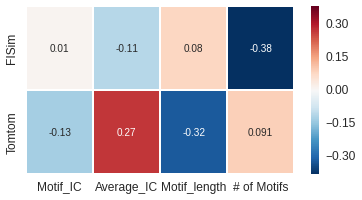

In [129]:
#Plot the mini-heatmap
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})
fig, ax1 = plt.subplots(figsize=(6, 3))
sns.heatmap(fisim_tomtom, annot=True, ax=ax1)
plt.savefig("/home/kipkurui/Dropbox/PHD/Documents/NAR_Paper/Working_draft/Figs/tomtom_fisim_corr_heatmap-sm.pdf", bbox_inches='tight')

The main difference is the apparent influence of IC on the scores assigned by the two techniques. Tomtom scores have a positive correlation wih average IC (favour hiher IC motifs) while Fisim has a negative correlation (penalize higher IC motifs). Fism is not infleunced by length while Tomtom penalizes longer motifs. Surprisingly, number of motifs in the TF seem to negatively affect motif scores for Fism and not efect for Tomtom.

The question now is, what is the meaning of all this? How much of it can be explained by the design of the motif comparison tools in use here? Also, the number of motifs in a set, could bring in diversity. Therefore we should not read much from it. 

#### Repeat the above for FiSim

In [134]:
cols = "Average_IC"
#fisim[cols].to_frame(name="Fisim").T.append(tomtom[cols].to_frame(name="Tomtom").T)

compare = fisim[cols].to_frame(name="Fisim").T.append(tomtom[cols].to_frame(name="Tomtom").T).T

ranksums(compare['Fisim'],compare['Tomtom'])[1]

0.00015457421710040657

<a id='figure4a'></a>
### Figure 4A: Correlating CB-MAR  with Energy AUC ranking in ChIP-seq data

In [4]:
here = pd.DataFrame()
enerrgy_mean = pd.DataFrame()
pbm_energy = pd.DataFrame()
tomtom_mean = pd.DataFrame()
fisim_mean = pd.DataFrame()
stat = "AUC"
chip_labels = []
for tf_id in over10_chip:
    #tf_name = pbmchip2name[tf_id]
    chip_labels.append(tf_classdisct[tf_id[:3]])
    tf_name = tf_id
    energy = pd.read_table("/home/kipkurui/Project/Motif_Assessment/PAPER_Assessment_Data/NAR_Paper/ChIP-seq/Results/%s/%s.energy" % (tf_id,tf_id), index_col="Motif")
    #pbms = pd.read_table("/home/kipkurui/Project/Motif_Assessment/PAPER_Assessment_Data/NAR_Paper/PBM/Results/%s/%s.energy" %s (tf_id, tf_id))
    a = energy[[stat]]
    e_mean = energy.mean().to_frame(name=tf_name)
    enerrgy_mean = enerrgy_mean.append(e_mean.T)
    
    
    results_path = "/home/kipkurui/Project/Motif_Assessment/PAPER_Assessment_Data/NAR_Paper/FisimTomtom/%s" % tf_id
    tomtom_sum = pd.read_table("%s/%s_fisim_ic.txt" % (results_path, tf_id),index_col="Motif_name")

    tomtom_sum.index.names = ["Motif"]

    b = tomtom_sum["Average"].to_frame(name="Fisim")

    fisim_mean = fisim_mean.append(b.mean().to_frame(name=tf_name).T)


    # #results_path = "/home/kipkurui/Project/Motif_Assessment/PAPER_Assessment_Data/NAR_Paper/FisimTomtom/%s" % tf_id
    tomtom_sum = pd.read_table("%s/%s_tomtom_ic.txt" % (results_path, tf_id), index_col="Motif_name")
    tomtom_sum.index.names = ["Motif"]
    c = tomtom_sum["Average"].to_frame(name="Tomtom")
    
    tomtom_mean = tomtom_mean.append(c.mean().to_frame(name=tf_name).T)

    d =a.T.append(b.T)

    total_cor = d.append(c.T).T.corr(method='pearson')
    #here = total_cor[stat].to_frame(name=pbmchip2name[tf_id])
    there = total_cor[stat].to_frame(name=tf_name)
    here = here.T.append(there.T).T

overall = here.T.drop(stat, axis=1)
overall_chip_unsorted = overall
overall_chip = overall.sort_values("Tomtom", ascending=False)
overall_chip.describe()

,Fisim,Tomtom
count,83.000000,83.000000
mean,0.646478,0.719150
std,0.318703,0.322177
min,-0.287187,-0.321046
25%,0.516138,0.626251
50%,0.781674,0.875551
75%,0.862488,0.928751
max,0.976314,0.975952


#### Get the TF-class details 

In [5]:
chip_labels = []
new_index = []
for tf_id in overall_chip.index:
    chip_labels.append(tf_classdisct[tf_id[:3]])
    new_index.append(pbmchip2name[tf_id])
overall_chip.index = new_index

#### Plot the bargraph with class details on the second axis

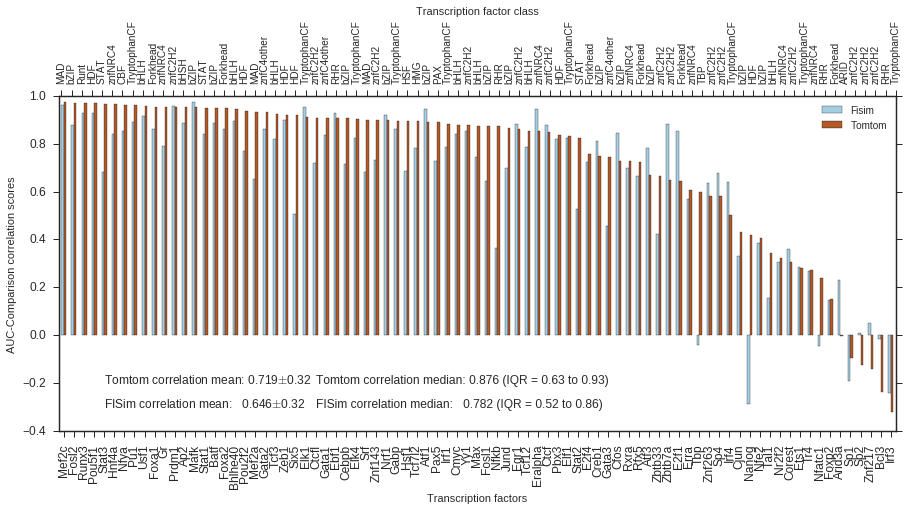

In [76]:
sns.set(style="ticks")
ax = overall_chip.plot(kind="bar", figsize=(15,6), fontsize=12, cmap='Paired') #, 
#plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
ax.set_xlabel("Transcription factors")
ax.set_ylabel("AUC-Comparison correlation scores")
ax.set_axis_on()

#Add a new x-axis on top of the figure
ax1 = ax.twiny()

#ax1.set_xlim(ax1.get_xlim())

ax1.set_xticks(np.array(range(1, len(overall_chip)+1))-0.75, minor=False)

ax1.set_xticklabels(chip_labels, rotation= 'vertical')

ax1.set_xlabel("Transcription factor class")

#Anotate teh figure with summary information 
ax.annotate("Tomtom correlation mean: %.3f$\pm$%.2f" % (overall_chip.mean()["Tomtom"], overall_chip.std()["Tomtom"]), (4,-0.20))
ax.annotate("Tomtom correlation median: %.3f (IQR = %.2f to %.2f)" % (overall_chip.median()["Tomtom"], overall_chip.quantile(.25)["Tomtom"], overall_chip.quantile(.75)["Tomtom"]), (25,-0.20))

ax.annotate("FISim correlation mean:   %.3f$\pm$%.2f" % (overall_chip.mean()["Fisim"], overall_chip.std()["Fisim"]), (4,-0.30))


ax.annotate("FISim correlation median:   %.3f (IQR = %.2f to %.2f)" % (overall_chip.median()["Fisim"], overall_chip.quantile(.25)["Fisim"], overall_chip.quantile(.75)["Fisim"]), (25,-0.30))

#ax.annotate("p-value (wilcoxon ranksum test):   %f" % ranksums(overall['Fisim'],overall['Tomtom'])[1], (5,-0.05))
fig = ax.get_figure()

#TODO: rethink how the figures will be stored for the paper

#fig.savefig('/home/kipkurui/Dropbox/PHD/Documents/NAR_Paper/Working_draft/Figs/fisim_tomtom_chip_tfclass_sorted_dark2.png', bbox_inches='tight')

A few observations can be made from this:a) The Low scores are due to Tfs which do not depict direct binding hence using sequence data for assessment do not work. The figure seems to depict that the FISim is better at predicting oin vitro binding (based on mean) than Tomtom. Interestingly also is that the motifs belong to the same TF class (HMG) have negative correlation with the PBM binding. If we assume, consistency based aproach captures the in vivo binding, it so seems then that the motifs have a different binding behaviour in vivo and in vitro. 

In [176]:
# d = pd.DataFrame()
# tomtom_mean = pd.DataFrame()
# for tf_id in over10_chip:
#     results_path = "/home/kipkurui/Project/Motif_Assessment/PAPER_Assessment_Data/NAR_Paper/FisimTomtom/%s" % tf_id
#     tomtom_sum = pd.read_table("%s/%s_tomtom_ic.txt" % (results_path, tf_id))
#     a = tomtom_sum.corr()
#     asd = pd.Series([len(tomtom_sum)],index=["Number"]).to_frame(pbmchip2name[tf_id])
#     means = tomtom_sum.mean().to_frame(name=pbmchip2name[tf_id])
#     means = means.append(asd)
#     tomtom_mean = tomtom_mean.append(means.T)
#     b = a['Average'].to_frame(name=pbmchip2name[tf_id])
#     d = d.append(b.T)
# tomtom = d.drop('Average', axis=1)
# energy_stat = tomtom_mean
# # fig, ax = plt.subplots()
# # # the size of A4 paper
# # fig.set_size_inches(10, 10)

# #sns.heatmap(tomtom, annot=True, ax = ax)



# enerrgy_mean = enerrgy_mean[["AUC"]]
# tets_this = energy_stat.T.append(enerrgy_mean[["AUC"]].T).T
# sns.heatmap(tets_this.corr(),annot=True)

<a id='figure5'></a>
### Figure 5: Correlating CB-MAR with Energy AUC ranking in PBM data

In [8]:
here = pd.DataFrame()
enerrgy_mean = pd.DataFrame()
pbm_energy = pd.DataFrame()
tomtom_mean = pd.DataFrame()
fisim_mean = pd.DataFrame()
stat = "AUC"

for tf_id in over10_pbm:
    #tf_name = pbmchip2name[tf_id]
    tf_name = tf_id
    #energy_chip = pd.read_table("/home/kipkurui/Project/Motif_Assessment/PAPER_Assessment_Data/NAR_Paper/ChIP-seq/Results/%s/%s.energy" % (tf_id,tf_id), index_col="Motif")
    energy = pd.read_table("/home/kipkurui/Project/Motif_Assessment/PAPER_Assessment_Data/NAR_Paper/PBM/Results/%s/%s.energy" % (tf_id, tf_id), index_col="Motif")
    a = energy[[stat]]
    e_mean = energy.mean().to_frame(name=tf_name)
    enerrgy_mean = enerrgy_mean.append(e_mean.T)
    
    
    results_path = "/home/kipkurui/Project/Motif_Assessment/PAPER_Assessment_Data/NAR_Paper/FisimTomtom/%s" % tf_id
    tomtom_sum = pd.read_table("%s/%s_fisim_ic.txt" % (results_path, tf_id),index_col="Motif_name")

    tomtom_sum.index.names = ["Motif"]

    b = tomtom_sum["Average"].to_frame(name="Fisim")

    fisim_mean = fisim_mean.append(b.mean().to_frame(name=tf_name).T)


    # #results_path = "/home/kipkurui/Project/Motif_Assessment/PAPER_Assessment_Data/NAR_Paper/FisimTomtom/%s" % tf_id
    tomtom_sum = pd.read_table("%s/%s_tomtom_ic.txt" % (results_path, tf_id), index_col="Motif_name")
    tomtom_sum.index.names = ["Motif"]
    c = tomtom_sum["Average"].to_frame(name="Tomtom")
    
    tomtom_mean = tomtom_mean.append(c.mean().to_frame(name=tf_name).T)

    d =a.T.append(b.T)

    total_cor = d.append(c.T).T.corr(method='pearson')
    #here = total_cor[stat].to_frame(name=pbmchip2name[tf_id])
    there = total_cor[stat].to_frame(name=tf_name)
    here = here.T.append(there.T).T

overall_pbm = here.T.drop(stat, axis=1)

overall_pbm = overall_pbm.sort_values("Fisim", ascending=False)

overall_pbm.describe()

,Fisim,Tomtom
count,59.000000,59.000000
mean,0.566404,0.524194
std,0.420491,0.439368
min,-0.660472,-0.600541
25%,0.432131,0.253104
50%,0.729011,0.739083
75%,0.843067,0.832422
max,0.960362,0.952384


In [9]:
#Uncomment below to get the figure legends
overall_pbm.sort_values(by="Fisim",ascending=False, inplace=True)
pbm_labels = []
new_index = []
for tf_id in overall_pbm.index:
    pbm_labels.append(tf_classdisct[tf_id[:3]])
    new_index.append(pbmchip2name[tf_id])
overall_pbm.index = new_index

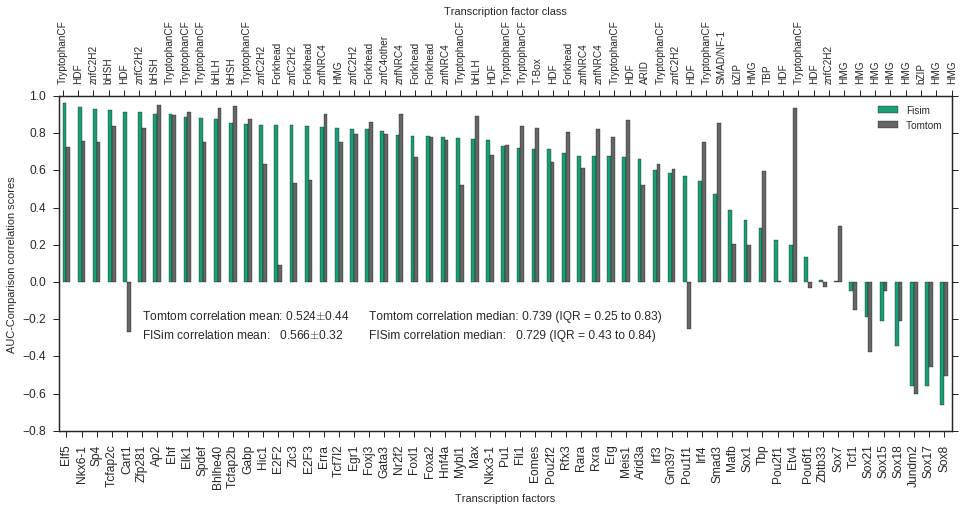

In [74]:
sns.set(style="ticks")

ax = overall_pbm.plot(kind="bar", figsize=(16,6), fontsize=12, cmap='Dark2') #cmap='Greys_r'

#Add a new x-axis on top of the figure
ax1 = ax.twiny()

#ax1.set_xlim(ax1.get_xlim())

ax1.set_xticks(np.array(range(1,len(overall_pbm)+1))-0.75, minor=False)

ax1.set_xticklabels(pbm_labels, rotation= 'vertical')

ax1.set_xlabel("Transcription factor class")


ax.set_xlabel("Transcription factors")
ax.set_ylabel("AUC-Comparison correlation scores")


ax.set_axis_on()


# ax.annotate("Tomtom correlation mean: %f" % overall_pbm.mean()["Tomtom"], (5,-0.20))
# ax.annotate("Tomtom correlation median: %f" % overall_pbm.median()["Tomtom"], (25,-0.20))

# ax.annotate("FISim correlation mean:   %f" % overall_pbm.mean()["Fisim"], (5,-0.30))

# ax.annotate("FISim correlation median:   %f" % overall_pbm.median()["Fisim"], (25,-0.30))

ax.annotate("Tomtom correlation mean: %.3f$\pm$%.2f" % (overall_pbm.mean()["Tomtom"], overall_pbm.std()["Tomtom"]), (5,-0.20))
ax.annotate("Tomtom correlation median: %.3f (IQR = %.2f to %.2f)" % (overall_pbm.median()["Tomtom"], overall_pbm.quantile(.25)["Tomtom"], overall_pbm.quantile(.75)["Tomtom"]), (20,-0.20))

ax.annotate("FISim correlation mean:   %.3f$\pm$%.2f" % (overall_pbm.mean()["Fisim"], overall_chip.std()["Fisim"]), (5,-0.30))


ax.annotate("FISim correlation median:   %.3f (IQR = %.2f to %.2f)" % (overall_pbm.median()["Fisim"], overall_pbm.quantile(.25)["Fisim"], overall_pbm.quantile(.75)["Fisim"]), (20,-0.30))


fig = ax.get_figure()

fig.savefig('/home/kipkurui/Dropbox/PHD/Documents/NAR_Paper/Working_draft/Figs/fisim_tomtom_pbm_corr_tfclass_dark2.png', bbox_inches='tight')

The median scores show that FISm and Tomtom do not differe as much in correlation with PBM energy scores. Also, this performance is lower as compared with that of ChIP-seq data, showing that Consistency-based approach better reproduces *in vivo* binding behaviour compared  with *in vitro* binding. Reporting the Median should be accompanied by the interquartile range of the data. Mdn = 0.72 (IQR = 0.2-0.84)

<a id='figure6'></a>
###  Figure 6: PBM ChIP-seq Energy AUC scores corelation

In [13]:
in_both = []
for tf in over10_pbm:
    if tf in over10_chip:
        in_both.append(tf)

In [14]:
pbm_chip_corr = pd.DataFrame()
stat = "AUC"

for tf_id in in_both:
    #tf_class.append(tf_classdisct[tf_id[:3]])
    #tf_name = pbmchip2name[tf_id]
    tf_name = tf_id
    energy_chip = pd.read_table("../ChIP-seq/Results/%s/%s.energy" % (tf_id,tf_id), index_col="Motif")
    
    energy = pd.read_table("../PBM/Results/%s/%s.energy" % (tf_id, tf_id), index_col="Motif")
    
    a = energy[[stat]]
    chip_e = energy_chip[[stat]]
    
    
    d = chip_e.corrwith(a)
    d = d.to_frame(name=tf_name)
    
    pbm_chip_corr = pbm_chip_corr.append(d.T)

In [15]:

pbm_chip_corr.sort_values(by="AUC", inplace=True, ascending=False)

pbm_chip_labels = []
new_index = []

for tf_id in pbm_chip_corr.index:
    pbm_chip_labels.append(tf_classdisct[tf_id[:3]])
    new_index.append(pbmchip2name[tf_id])
pbm_chip_corr.index = new_index


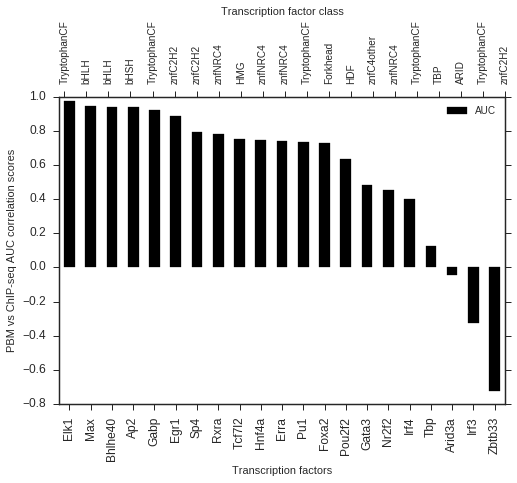

In [16]:
#May need to find a way of ensuring the figures are of an approriate size for ease in plotting. 
#pbm_chip_corr.sort_values(by="AUC", inplace=True, ascending=False)
sns.set_context("paper")
plt.figure(figsize=(8, 6))
sns.set(style="ticks")
ax = pbm_chip_corr.plot(kind="bar", cmap='Greys_r', fontsize=12)
ax.set_xlabel("Transcription factors")
ax.set_ylabel("PBM vs ChIP-seq AUC correlation scores")

#Uncomment below to add x-axis on top
ax1 = ax.twiny()

#ax1.set_xlim(ax1.get_xlim())

ax1.set_xticks(np.array(range(1, len(pbm_chip_corr)+1))-0.75, minor=False)

ax1.set_xticklabels(pbm_chip_labels, rotation= 'vertical')

ax1.set_xlabel("Transcription factor class")

#sns.despine()
plt.savefig('/home/kipkurui/Dropbox/PHD/Documents/NAR_Paper/Working_draft/Figs/pbm_chip_correlation-ticks-black-tf_class.pdf', bbox_inches='tight')


We can see the same observation here as well. The ranks and scores of motifs that do not bind directly, or have a different binding behaviour in vitro, will generally not agree. Since they do not have a binding site, sequence based assessment, or any assessment for that matter, will not agree with any other.

## Histogram and Scatter plot

The figure demonstrates the skew in the data and the reason why using mean would not be appropriate, but rather that we need to use Median score. Using Median, retains our analsysis that our approach is greatly coorrelated with the scores assigned by Energy score

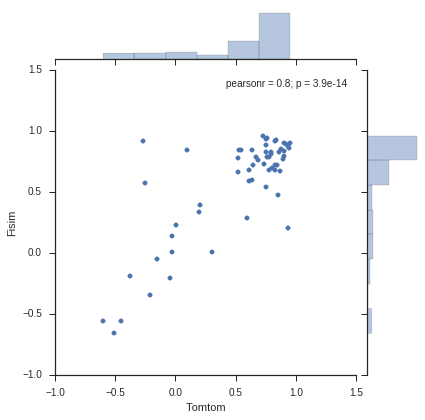

In [17]:
sns.set(style="ticks")
#sns.set_cmap(cmap='Greys_r')

sns.jointplot(x="Tomtom", y="Fisim", data=overall_pbm)
plt.set_cmap('Greys_r')
plt.savefig('/home/kipkurui/Dropbox/PHD/Documents/Phd_Thesis/Chapter4/Figs/fisim_tomtom-jointplot-pbm.pdf', bbox_inches='tight')


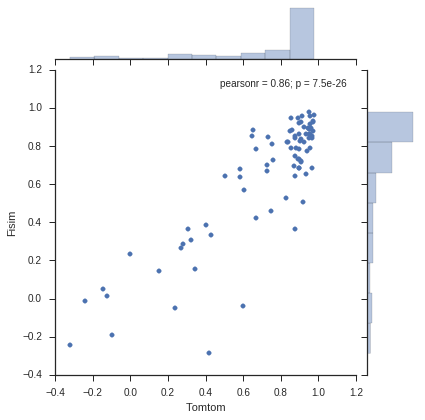

In [18]:
sns.set(style="ticks")
sns.jointplot(x="Tomtom", y="Fisim", data=overall_chip)
plt.savefig('/home/kipkurui/Dropbox/PHD/Documents/Phd_Thesis/Chapter4/Figs/fisim_tomtom-jointplot-chip.png', bbox_inches='tight')

It is clear that the correlation of the Tfs is greatly skewed by the bottom 10 motifs. 

<a id='gimme_roc'></a>
## Run Gimme Roc Analsysis

We may have to transfer all these into their own module and just import it here for clarity and independence of the tool

In [19]:
def tab2fasta(posneg, fasta, background):
    """
    Convert the posneg format into fasta needed by gimme motifs
    """
    i = 0
    #print fasta
    with open(posneg) as tab:
        with open(fasta, 'w') as fa:
            with open(background, 'w') as bg:
                for line in tab:
                    details = line.split()
                    if len(details) == 2:
                        pos = 1
                    else:
                        pos = 2
                    if i < 500:
                        fa.write(">"+line.split()[0]+'\n'+line.split()[pos]+"\n")
                    else:
                        bg.write(">"+line.split()[0]+'\n'+line.split()[pos]+"\n")
                    i += 1

def meme2gimme(meme, gimme):
    """
    Convert the motifs in meme format to gimme format
    """
    with open(meme) as motif:
        with open(gimme, 'w') as gmotif:
            for line in motif:
                if line.startswith("MOTIF"):
                    if len(line.split(" ")) > 2:
                        gmotif.write(">"+line.split(" ")[1]+"\n")
                    else:
                        gmotif.write(">"+line.split(" ")[1])
                elif line.startswith('letter-probability'):
                    continue
                elif line.startswith('  '):
                    a = line.split()
                    if len(a)>0:
                        gmotif.write(a[0]+'\t'+a[1]+'\t'+a[2]+'\t'+a[3]+'\n')
                    else:
                        continue
                elif line.startswith("\n"):
                    continue
                else:
                    continue

def run_gimme(tf_id, meme_path, chip_seq_list, results_path):
    """
    Run complete analysis from extracting the right sequneces 
    to computing roc metrics
    """
    import os
    import glob
    #mkdir_p(results_path)
    if os.path.isdir(results_path):
        pass
    else:
        os.makedirs(results_path)
    
    #run_all(tf_id,'energyscore',meme_path,chip_seq_list,results_path)
    #files_path = '%s/%s' % (results_path, tf_id)
    pwm = '%s/%s.pwm' % (results_path, tf_id)
    meme2gimme(meme_path, pwm)
    
    for chip_seq in chip_seq_list:
        file_name = chip_seq.split('/')[-1].split('.')[0]
        
        Tf_path = '%s/%s' % (results_path, file_name)
        
        tab2fasta(chip_seq, "%s.fa" % Tf_path, '%s.bg' % Tf_path)
    
        
        !gimme roc {pwm} {Tf_path}.fa {Tf_path}.bg >>{results_path}/{tf_id}_gimme_metrics.txt
        
        #os.system("gimme roc %s/%s.pwm %s/%s.fa %s/%s.bg >>%s/%s_gimme_metrics.txt" %
#                   #(files_path, tf, files_path, file_name, files_path, file_name, files_path, tf))
    for i in glob.glob('%s/*.bg' % results_path):
        os.remove(i)
    for i in glob.glob('%s/*.fa' % results_path):
        os.remove(i)

def clean_gimme(gimme_in, gimme_out):
    """
    Function that cleans the GIMME output for the purpose of plotting the data
    """
    with open(gimme_in) as gim:
        with open(gimme_out, 'w') as outs:
            outs.write("Motif	ROC AUC	MNCP	Max f-measure	Sens @ max f-measure\n")
            for line in gim:
                if line.startswith("Motif"):
                    continue
                else:
                    outs.write(line)

#### Again we demonstrate this using Jun

Data is located in the Example folde

In [194]:
import glob
tf_id = "Jun"
meme_path = "./Example_data/Jun.meme"
posneg_path = "./Example_data"

# Get a list of posneg formatted ChIP-seq data
chip_seq_list = glob.glob('./Example_data/%s/*' % tf_id)
results_path = "./Example_data/%s_GimmeRoc" % tf_id

#Compute roc metrics using available data
run_gimme(tf_id, meme_path, chip_seq_list, results_path)


gimme_in = "%s/%s_gimme_metrics.txt" % (results_path, tf_id)
gimme_out = "%s/%s.gimme" % (results_path, tf_id)

#Clean the gimme roc output
clean_gimme(gimme_in, gimme_out)

gimme = pd.read_table(gimme_out)

new_gimme = pd.pivot_table(gimme, index=['Motif'])

new_gimme = new_gimme.sort_values(by="ROC AUC", axis=0, ascending=False)
labels = new_gimme.index
new_gimme.to_csv(gimme_out,sep="\t")

#### First we remove the TFs that did not have approapriate test data"

In [20]:
for tf_id in ('2.3.3.0.6', '4.1.6.1.1'):
    chipseq.remove(tf_id)

#### Finally, we can run complete *gimme roc*  for all the ChIP-seq data available

In [21]:
import pandas as pd
import glob
for tf_id in chipseq:
    results_path = "../GimmeRoc/%s" % tf_id
    if tf_id == "Tf_id":
        continue
    elif os.path.isdir(results_path):
        continue
    else:
        
        run_gimme(tf_id, meme_path, chip_seq_list, results_path)
        gimme_in = "%s/%s_gimme_metrics.txt" % (results_path, tf_id)
        gimme_out = "%s/%s.gimme" % (results_path, tf_id)

        clean_gimme(gimme_in, gimme_out)

        gimme = pd.read_table(gimme_out)
        
        new_gimme = pd.pivot_table(gimme, index=['Motif'])
        
        new_gimme = new_gimme.sort_values(by="ROC AUC", axis=0, ascending=False)
        labels = new_gimme.index
        new_gimme.to_csv(gimme_out,sep="\t")



#### Combine Gimme and Energy data for plotting

In [22]:
gimme_ennergy_frame=pd.DataFrame()
for tf_id in chipseq:
    results_path ="/home/kipkurui/Project/Motif_Assessment/PAPER_Assessment_Data/NAR_Paper/GimmeRoc/%s" % tf_id
    energy = pd.read_table("/home/kipkurui/Project/Motif_Assessment/PAPER_Assessment_Data/NAR_Paper/ChIP-seq/Results/%s/%s.energy" % (tf_id,tf_id), index_col="Motif")
    
    auc_raw = energy.sort_index()
    
    tests = pd.read_table("%s/%s.gimme" % (results_path,tf_id), index_col="Motif")
    b = tests.sort_index()
    if len(auc_raw) == len(b):
        added = auc_raw.T.append(b.T).T
        gimme_energy = added[['AUC','ROC AUC']]
        a = gimme_energy.mean().to_frame(name=pbmchip2name[tf_id])
        gimme_ennergy_frame = gimme_ennergy_frame.append(a.T)

gimme_ennergy_frame.columns = ["Energy Scoring", 'Gimme roc']  

In [ ]:
st

<a id='figure7'></a>
### Figure 7: Joint scatter plot and histogram for gimme roc and Energy scoring Correlation scores

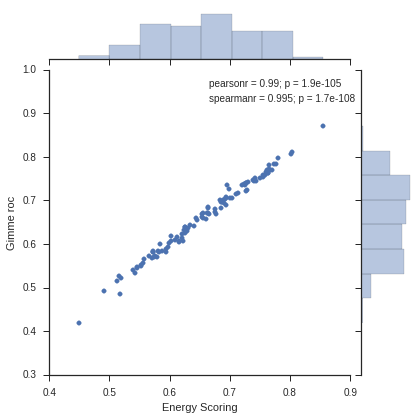

In [27]:
sp = stats.spearmanr(gimme_ennergy_frame["Energy Scoring"],gimme_ennergy_frame['Gimme roc'])[0]
pv = stats.spearmanr(gimme_ennergy_frame["Energy Scoring"],gimme_ennergy_frame['Gimme roc'])[1]

p = sns.jointplot(x="Energy Scoring", y="Gimme roc", data=gimme_ennergy_frame)
sns.set_context("notebook")
#Annotate Spearmans correlation details into the figure
p.fig.text(0.5, 0.75, "spearmanr = %.3f; p = %.1e"%(sp,pv), ha ='left', fontsize = 10)
plt.savefig('/home/kipkurui/Dropbox/PHD/Documents/NAR_Paper/Working_draft/Figs/Gimme_energy-jointplot.pdf', bbox_inches='tight')

#### Doing the above in the least number of lines

I will jsut need to find the best way to use this: df.reindex(np.random.permutation(df.index)) to shuffle the bed files and then at the same processing step also extrat the negative sequences that will be used for the validation step. The idea is to run the get bed, return a bed data frame and use that to combine all the data frames for a given TF, shuffle them up and finally extract the respective sequences using pybedtools. This idea should be able to combine all the data prpcessing steps quickly. The only tricky step is to be able to gte negative sequences without repeats.

The solution for this is to get all the positive and negatoive data, especially specific to the test question. Remember, it really doesn't matter is teh negative sequence do not match with positive in terms of position, as long as they are in regions not known tpo contain binding sites. 

That way, we can only retain data that is necessary for teh analsysis. Having too much unused data is just a waste of memory

<a id='discover_meme'></a>
### Motif discovery with GIMME

We use this to test the utility of consistency based motif assessment, especially using Tomtom in motif discovery. The steps are as follows:
1. Perform motif discovery using gimme motifs and keep intermediate data (Use 50%)
2. Use Tomtom and motif clustering to get the best three motifs from motif discovery
3. Compare the perofmance of teh motufs identified purely buy gimme versus those based on tomtom
4. Report

#### 1. Data processing

For a given TF, we querried the database for the raw chiP-seq peaks, but for demonsration purpose we just use a single peak file located in teh Example folder. Remeber, some Tfs will have upto 50 peak files. 

In [68]:
def get_bed_from_peaks(peak, width, downstream_distance):
    """
    Given a bed file, extract the fasta in tab format and eliminate the masked sequences,
    and extract the negative version of the file
    
    """
    #Read the narrow peak file into a pandas DataFrame
    
    peak_file = pd.read_table(peak, header=None)[[0,1,2]]
    
    #Lets widden the coordinates to 100bp centered around the center
    mid = (peak_file[2] + peak_file[1])/2
    peak_file[1] = (mid - width/2+0.5).apply(int)
    peak_file[2]  = (mid + width/2+0.5).apply(int)
    
    #Extract the negative set located 500bp downstream
    neg_bed = peak_file.copy(deep=True)
    
    neg_bed[1] = neg_bed[1]+downstream_distance
    neg_bed[2] = neg_bed[2]+downstream_distance
    
    # Eliminate repeat masked regions from the bed file
    peak_file = remove_repeats(peak_file) #.to_csv(pos_bed_out, index=None, header=None, sep="\t")
    neg_bed = remove_repeats(neg_bed) #.to_csv(neg_bed_out, index=None, header=None, sep="\t")
    
    #hg = "/home/kipkurui/Project/MAT_server/Data/hg19.fa"
    return peak_file, neg_bed
    #pybedtools.BedTool.from_dataframe(peak_file).sequence(fi=hg,).save_seqs(negfa_out)

In [53]:
import glob
jun_peaks = glob.glob("./Example_data/Raw_chip/Jun/*")

pos_bed_cum = pd.DataFrame()
neg_bed_cum = pd.DataFrame()
for peak in jun_peaks:
    width = 100
    downstream_distance = 500
    
    bed_df = get_bed_from_peaks(peak, width, downstream_distance)
    
    pos_bed_cum = pos_bed_cum.append(bed_df[0], ignore_index=True)
    neg_bed_cum = neg_bed_cum.append(bed_df[1], ignore_index=True)

In [67]:
discover_out = "./Example_data/Jun_discover.fa"
test_pos_out = "./Example_data/Jun_test_pos.fa"
test_neg_out = "./Example_data/Jun_test_neg.fa"

randomized_pos = pos_bed_cum.reindex(np.random.permutation(pos_bed_cum.index))

discover = randomized_pos.head(len(pos_bed_cum)*4/5)

test_pos = randomized_pos.tail(len(pos_bed_cum)/5)

#for negative, we just sample a subset similar to the test positive set
test_neg = neg_bed_cum.sample(len(pos_bed_cum)/5)

hg = "/home/kipkurui/Project/MAT_server/Data/hg19.fa"
#Then for each of the sets, lets get the fasta sequences
pybedtools.BedTool.from_dataframe(discover).sequence(fi=hg,).save_seqs(discover_out)

pybedtools.BedTool.from_dataframe(test_pos).sequence(fi=hg,).save_seqs(test_pos_out)

pybedtools.BedTool.from_dataframe(test_neg).sequence(fi=hg,).save_seqs(test_neg_out)

<BedTool(/tmp/pybedtools.bLD_pn.tmp)>

#### 2. Run Gimme motif discovery

Using the discover fasta sequences, we can now peroform motif discovery on the sequences. Using shuffled sequences ensures that we generate a generalized model. 

Gimme internally perfoms m

In [69]:
for tf_id in chipseq:
    results_path = "../GimmeMars/%s" % tf_id
    if tf_id == "Tf_id":
        continue
    else:
        !gimme motifs {results_path}/{tf_id}_discover.fa -k -t MDmodule,MEME,MotifSampler,trawler,Improbizer,BioProspector,Posmo,ChIPMunk,AMD,HMS,Homer -n {results_path}/{tf_id}_discover
    

#### 4. Run complete clustering of the motifs discovered by GimmeMotifs

In order to us Tomtom ranking, the motifs are first clustred in that, when predicting motifs, the best three located in different clusters can be extracted. This is the first ooption, the other is to just use the fisim clustering, whcihactually takes a shorter time and produces similar results. 

##### a) Usng gimme cluster

In [18]:
for tf_id in chipseq:
    results_path = "../GimmeMars/%s" % tf_id
    if tf_id == "Tf_id":
        continue
    else:
        pfm_in = "%s/%s_discover_all_motifs.pfm" % (results_path, tf_id)
        out_folder = "%s/%s_discover_cluster" % (results_path,tf_id)
        if os.path.isdir(out_folder):
            continue
        else:
            !gimme cluster {pfm_in} {out_folder}

##### b) using kcmeans by FISim

This is the shorter and faster way directly clustering the similarity scores from Tomtom

NB: I need to chnage the loctation of the scripts and just use a relative path

In [70]:
for tf_id in chipseq:
    if tf_id == "Tf_id":
        continue
    else:
        results_path = "../GimmeMars/%s" % tf_id
        tomtom_raw = "%s/%s.tomtom_raw.txt" % (results_path, tf_id)

        !python /home/kipkurui/Project/MAT_server/MARST_Suite/FISIM/kcmeans.py -fileIn {tomtom_raw} -o {results_path}/{tf_id}_cluster.txt -k 20  >"delete_this"      

#### 5. Motif ranking using Tomtom and clustering

This is carried out in two stages; first we rank the motifs using pairwise similarity, then we get the best non-redubdant motifs by combining with clustering done above. 

##### a) Ranking with Tomtom (Consisency-based motif assessment)

In [ ]:
for tf_id in chipseq:
    if tf_id == "Tf_id":
        continue
    else:
        print(tf_id)
        results_path = "../GimmeMars/%s" % tf_id
        pfm_all = "%s/%s_discover_all_motifs.pfm" % (results_path, tf_id)
        meme_all = "%s/%s_discover_all_motifs.meme" % (results_path, tf_id)
        tomtom_raw = "%s/%s.tomtom_raw.txt" % (results_path, tf_id)
        gimmepfm2meme(pfm_all,meme_all)
        run_tomtom(tf_id, meme_all,results_path)

##### b) Extract the best three motifs based on each of the clustering aproaches for comparison

In [ ]:
for tf_id in chipseq:
    if tf_id == "Tf_id":
        continue
    else:

        results_path = "../GimmeMars/%s" % tf_id
        tomtom_raw = "%s/%s.tomtom_raw.txt" % (results_path, tf_id)
        pfm_all = "%s/%s_discover_all_motifs.pfm" % (results_path, tf_id)
        
        mot_list = !cut -f1 {tomtom_raw}
        
        #get top three from gimme clustering
        cluster_key = "%s/%s_discover_cluster/cluster_key.txt" % (results_path, tf_id)
        prefix = "gimme_top3"
        discover_three_gimme = get_top_from_gimme(cluster_key, mot_list)
        discover_best_gimme = "%s/%s_discover_best_gimme_top3.pwm" % (results_path,tf_id)
        extract_pfm(pfm_all,discover_best_gimme,discover_three_gimme)
            
        #get top three from FISim clustering
        cluster_key = "%s/%s_cluster.txt" % (results_path, tf_id)
        prefix = "fisim_top3"        
        discover_three_fisim = get_top_from_fisim(cluster_key, mot_list)
        discover_best_fisim = "%s/%s_discover_best_fisim_top3.pwm" % (results_path,tf_id)
        extract_pfm(pfm_all,discover_best_fisim,discover_three_fisim)
        


        
        pfm_gimme = '%s/%s_discover_motifs.pwm' % (results_path,tf_id)

        #Get the best motifs discovered using a given technique
        
        gimme_len = !wc -l {results_path}/{tf_id}_discover_motif_report.tsv |cut -f1 -d" "
        
        #First check the number of motifs identified by Gimme
        if int(gimme_len[0])-1 <3:
            n = int(gimme_len[0])-1
            #n=1
        else:
            n = 3
        
        # Get a list of the best three motifs in Gimme 
        gimme_three = ! cut -f1 {results_path}/{tf_id}_discover_motif_report.tsv |head -4 |tail -{n}
        
        gimme_out = '%s/%s_gimme_best_three.pwm' % (results_path,tf_id)
        extract_pfm(pfm_gimme,gimme_out,gimme_three)


##### c) Then we can compare the perfomance of each of the clusteirng techniques against Gimme motifs. 

At this stage we use the test or validation partition of the data

In [ ]:
for tf_id in chipseq::
    results_path = "../GimmeMars/%s" % tf_id
    for prefix in ("fisim", "gimme")
    
        !cat {results_path}/{tf_id}_gimme_best_{prefix}.pwm {results_path}/{tf_id}_discover_best.pwm >{results_path}/{tf_id}_combined_best_{prefix}.pwm

        !gimme roc {results_path}/{tf_id}_combined_best_{prefix}.pwm {results_path}/{tf_id}_test.fa {results_path}/{tf_id}_bg.fa >{results_path}/{tf_id}_roc-{prefix}.tcx

#### Then try and compare how the two clustering algorithms compare with each other. 

In [18]:
def get_top_from_fisim(cluster_key, yylist, get_no):
    with open(cluster_key) as cluster:
        all_clusters = cluster.readlines()
    mot_lits = []
    for mot in yylist:
        for i in all_clusters:
            new_list = i.split()
            if mot in new_list:
                mot_lits.append(mot)
                all_clusters.remove(i)
    discover_three = mot_lits[:get_no]

    return discover_three

def get_top_from_gimme(cluster_key, yylist):
    with open(cluster_key) as cluster:
        all_clusters = cluster.readlines()
    mot_lits = []
    for mot in yylist:
        for i in all_clusters:
            new_list = i.split()[1].split(',')
            if mot in new_list:
                mot_lits.append(mot)
                all_clusters.remove(i)
    discover_three = mot_lits[:get_no]

    return discover_three

Now we can get the best non-redudant motifs uising Fisim or gimme clustering

##### Compare the perfomance of fisim and gimme clustering for motif choice

In [463]:
#all_scores_fisim = []
sizes_gimme = []
for tf_id in chipseq:
    results_path = "/home/kipkurui/Project/Motif_Assessment/PAPER_Assessment_Data/NAR_Paper/GimmeMars/%s" % tf_id
    prefix = "fisim_top3" 
    #wc -l {results_path}/{tf_id}_roc-{prefix}.tcx |cut -f1
    #cluster_key = "%s/%s_cluster.txt" % (results_path, tf_id)
    cluster_key = "%s/%s_discover_cluster/cluster_key.txt" % (results_path, tf_id)
    
    a = !wc -l {cluster_key} | cut -f1 -d" "
    sizes_gimme.append(int(a[0]))
    #res = "%s/%s_roc-%s.tcx" % (results_path, tf_id, prefix)
    #all_scores_fisim.append(pd.read_table(res)['ROC AUC'].mean())

In [465]:
np.mean(sizes)

15.881818181818181

In [450]:
np.mean(all_scores_fisim)

0.74337954545454554

In [445]:
all_scores_gimme = []
for tf_id in chipseq:
    results_path = "../GimmeMars/%s" % tf_id
    prefix = "gimme_top3" 
    res = "%s/%s_roc-%s.tcx" % (results_path, tf_id, prefix)
    all_scores_gimme.append(pd.read_table(res)['ROC AUC'].mean())

In [449]:
np.mean(all_scores_gimme)

0.71444621212121218

This quick and dirty approach actually tells us that the clustering by Fisim, or rather teh cut-off used generates motifs of  ahigher quality. The next question of coz would be, how big are the clusters? Interstingly the cluster sizes are bigger from gimme, meaning that highly similar ones are clustered closely

In [688]:
for tf_id in Compare_big_diff:
    if tf_id == "Tf_id":
        continue
    else:
        
        results_path = "/home/kipkurui/Project/Motif_Assessment/PAPER_Assessment_Data/NAR_Paper/GimmeMars/%s" % tf_id
        tomtom_raw = "%s/%s.tomtom_raw.txt" % (results_path, tf_id)
        cluster_key = "%s/%s_discover_cluster/cluster_key.txt" % (results_path, tf_id)
        yylist = !cut -f1 {tomtom_raw}
        with open(cluster_key) as cluster:
            all_clusters = cluster.readlines()
        mot_lits = []
        for mot in yylist:
            for i in all_clusters:
                new_list = i.split()[1].split(',')
                if mot in new_list:
                    mot_lits.append(mot)
                    all_clusters.remove(i)
        discover_three = mot_lits[:1]
        #print(discover_three)
        pfm_all = "%s/%s_discover_all_motifs.pfm" % (results_path, tf_id)
        pfm_gimme = '%s/%s_discover_motifs.pwm' % (results_path,tf_id)

        discover_best = "%s/%s_discover_best.pwm" % (results_path,tf_id)
        extract_pfm(pfm_all,discover_best,discover_three)


        gimme_len = !wc -l {results_path}/{tf_id}_discover_motif_report.tsv |cut -f1 -d" "

        if int(gimme_len[0])-1 <3:
            #n = int(gimme_len[0])-1
            n=1
        else:
            n = 1
        gimme_three = ! cut -f1 {results_path}/{tf_id}_discover_motif_report.tsv |head -4 |tail -{n}
        gimme_out = '%s/%s_gimme_best.pwm' % (results_path,tf_id)
        extract_pfm(pfm_gimme,gimme_out,gimme_three)

        !cat {results_path}/{tf_id}_gimme_best.pwm {results_path}/{tf_id}_discover_best.pwm >{results_path}/{tf_id}_combined_best.pwm

        #print(chipid2name[tf_id])

        !gimme roc {results_path}/{tf_id}_combined_best.pwm {results_path}/{tf_id}_test.fa {results_path}/{tf_id}_bg.fa >{results_path}/{tf_id}_roc-third.tcx

##### d) Prepare the Gimme and Tomtom motifs for plotting. 

The intention here is to compare the best motifs generated using Tomtom and those generated using Gimmes own ranking system. For comparison we, get the best motif identified by gimme and Tomtom and compare their roc scores on the held pout data 

In [175]:
all_roc = pd.DataFrame()
for tf_id in chipseq:
    #print(tf_id,pbmchip2name[tf_id])
    results_path = "../GimmeMars/%s" % tf_id
    roc_code ="%s/%s_roc.tcx" % (results_path, tf_id)
    roc_data = pd.read_table(roc_code, index_col="Motif")
    keep = pd.read_table(roc_code, index_col="Motif")
    if 'GimmeMotifs' in keep.index[0]:
        g_i = 0
        c_i =1
    else:
        g_i = 1
        c_i = 0
    c = roc_data['ROC AUC'].to_frame(name=tf_id).T
    new_columns = c.columns.values; new_columns[g_i] = 'Gimme'; new_columns[c_i] = 'Compare'; c.columns = new_columns
    
    all_roc = all_roc.append(c)   
Gimme_all_roc = all_roc.sort_values(by="Compare", ascending=True)

NameError: name 'pd' is not defined

###### Further investigation of the TFs that significantly differeed in perofmance, by 0.1

Using this to change the location the position of the chosen motif from the Tomtom values

In [183]:
Compare_big_diff2 =[]
for index, row in Gimme_all_roc.iterrows():
    if row.Compare - (row.Gimme) >0.1:
        Compare_big_diff2.append(index)

In [185]:
labels2 = []
new_index = []

for tf_id in Compare_big_diff2:
    labels2.append(tf_classdisct[tf_id[:3]])
    #new_index.append(pbmchip2name[tf_id])
#pbm_chip_corr.index = new_index

In [689]:
check_roc = pd.DataFrame()
for tf_id in Compare_big_diff:
    results_path = "/home/kipkurui/Project/Motif_Assessment/PAPER_Assessment_Data/NAR_Paper/GimmeMars/%s" % tf_id
    roc_code ="%s/%s_roc-third.tcx" % (results_path, tf_id)
    roc_data = pd.read_table(roc_code, index_col="Motif")
    #print(chipid2name[tf_id], roc_data)
    keep = pd.read_table(roc_code, index_col="Motif")
    if 'GimmeMotifs' in keep.index[0]:
        g_i = 0
        c_i =1
    else:
        g_i = 1
        c_i = 0
    c = roc_data['ROC AUC'].to_frame(name=pbmchip2name[tf_id]).T
    new_columns = c.columns.values; new_columns[g_i] = 'Gimme'; new_columns[c_i] = 'Compare'; c.columns = new_columns
    
    check_roc = check_roc.append(c)   
check_gimme3 = check_roc.sort_values(by="Compare", ascending=True)

#### Adjust the colum names 

In [693]:
check_gimme1.columns = ["Compare","Gimme1"]
check_gimme2.columns = ["Compare", "Gimme2"]
check_gimme3.columns = ["Compare","Gimme3" ]

In [698]:
Gimme_top3 = check_gimme1.reset_index().merge(check_gimme2, how="left").set_index('index')
Gimme_top3 = Gimme_top3.reset_index().merge(check_gimme3, how="left").set_index('index')
Gimme_top3 = Gimme_top3.sort_values(by="Compare") #This sorting was just doen to ensure teh lgened is properly placed
Gimme_top3.index.name = "Motifs"

In [700]:
Gimme_top3.to_csv("Gimme_top3.txt", sep="\t")

In [187]:
Gimme_top3 = pd.read_table("Gimme_top3.txt", index_col="Motifs")

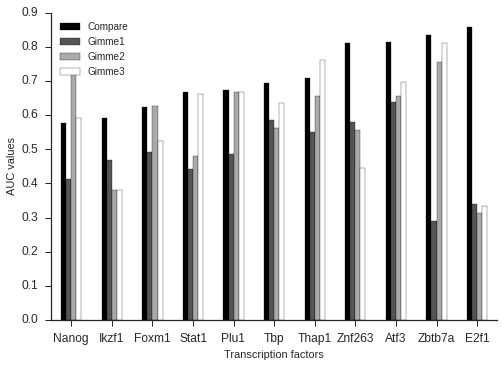

In [702]:
sns.set(style="ticks")
ax = Gimme_top3.plot(kind="bar", fontsize=12, rot=0,cmap='gray')
ax.set_xlabel("Transcription factors")
ax.set_ylabel("AUC values")
sns.despine()
plt.savefig('../Figs/Gimme_top3-greys.pdf', bbox_inches='tight')

In [509]:
all_roc.columns = ["Compare1","Gimme"]
check_second.columns = ["Compare2", "Gimme"]
check_third.columns = ["Compare3","Gimme" ]

#### Then Merge the data

In [529]:
new_merge = all_roc2.reset_index().merge(check_second, how="left").set_index('index')
new_merge = new_merge.reset_index().merge(check_third, how="left").set_index('index')
new_merge = new_merge.sort_values(by="Gimme") #This sorting was just doen to ensure teh lgened is properly placed
new_merge.index.name = "Motifs"

In [687]:
new_merge.to_csv("Consistency_top3_motifs.txt", sep="\t")

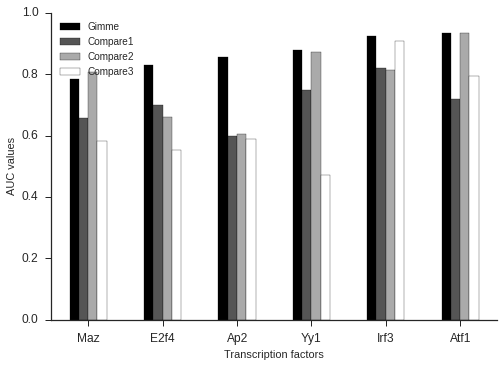

In [531]:
sns.set(style="ticks")
ax = new_merge.plot(kind="bar", fontsize=12, rot=0,cmap='gray')
ax.set_xlabel("Transcription factors")
ax.set_ylabel("AUC values")
sns.despine()
plt.savefig('/home/kipkurui/Dropbox/PHD/Documents/NAR_Paper/Working_draft/Figs/Consistency_top3-greys.pdf', bbox_inches='tight')

We observer some improvement in the peromance of the chosen motifs when the second best motif predicted by our approach is chosen. In these cases, we can argue that since a user would normally select more than one motif for comparison, we consider our approach validated as a useful tool for performing data independednt validation of the motifs predicted. This avoids any scoring bias that may arise, especially when the data were predicted from different algorithms. In choosing the third motif, the quality of Irf3 motif improved by close to 0.1. 

In [38]:
new_merge = pd.read_table("Consistency_top3_motifs.txt", index_col="Motifs")
Gimme_top3 = pd.read_table("Gimme_top3.txt", index_col="Motifs")

<a id='figure8'></a>
### Figure 8: Comparing performance of top three motifs in Gimme and CB-MAR

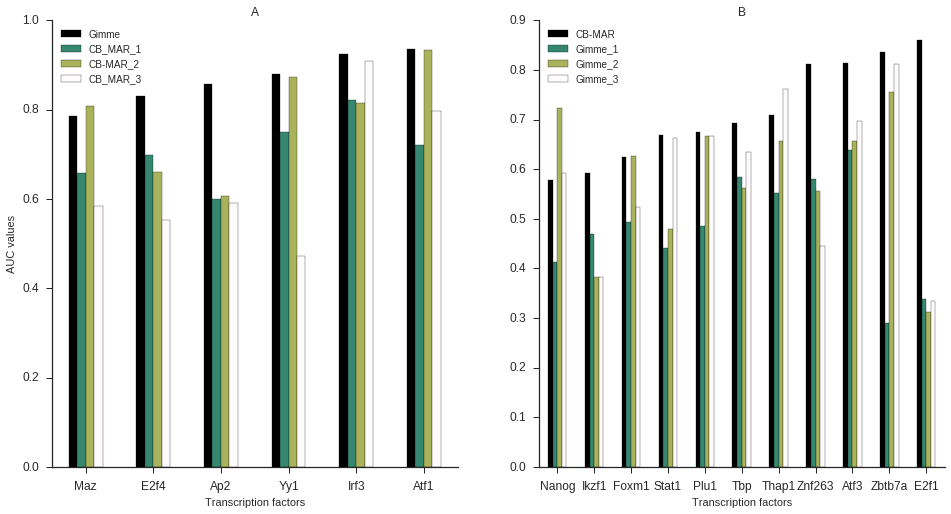

In [62]:
sns.set_style("ticks")
f, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(16, 8))
new_merge.plot(kind="bar", fontsize=12, rot=0,cmap='gist_earth', ax=ax1)
Gimme_top3.plot(kind="bar", fontsize=12, rot=0,cmap='gist_earth', ax=ax2)
ax1.set_xlabel("Transcription factors")
ax1.set_title("A")
ax2.set_xlabel("Transcription factors")

ax2.set_title("B")
ax1.set_ylabel("AUC values")
sns.despine()

plt.savefig('/home/kipkurui/Dropbox/PHD/Documents/NAR_Paper/Working_draft/Figs/Consistency_Gimme_top3_gist_earth.png', bbox_inches='tight')

In [144]:
results_path = "/home/kipkurui/Project/Motif_Assessment/PAPER_Assessment_Data/NAR_Paper/GimmeMars/%s" % tf_id
roc_code ="%s/%s_roc_top3.tcx" % (results_path, tf_id)
roc_data = pd.read_table(roc_code, index_col="Motif")

Get those scenarios in which my approach differes from the other by 0.05 AUC score. This is to see if the difference can be alleviated is I am to focus on the second motif. 

In [738]:
stats.pearsonr(Gimme_all_roc['Compare'],Gimme_all_roc['Gimme'])
#stats.spearmanr(Gimme_all_roc['Compare'],Gimme_all_roc['Gimme'])
# sp = stats.spearmanr(gimme_ennergy_frame['AUC'],gimme_ennergy_frame['ROC AUC'])[0]
# pv = stats.spearmanr(gimme_ennergy_frame['AUC'],gimme_ennergy_frame['ROC AUC'])[1]

(0.74382633825937983, 1.2931687371175491e-20)

<a id='figs1'></a>
### Supplementary Figure 1: Gimme motifs and consistency motif ranking comparison. 

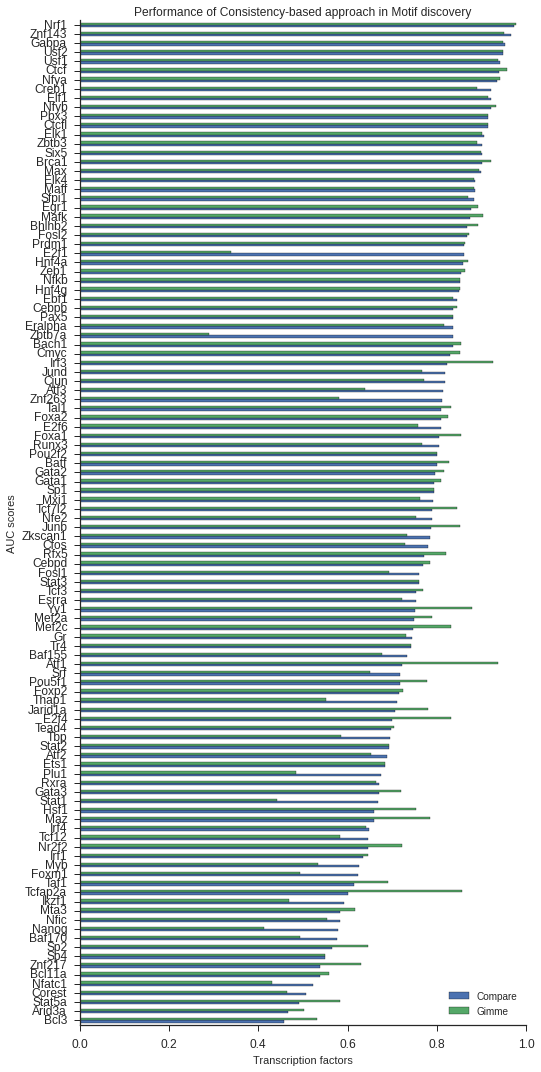

In [741]:
sns.set(style="ticks")
ax = Gimme_all_roc.plot(kind="barh", title="Performance of Consistency-based approach in Motif discovery", figsize=(8,18), fontsize=12)
ax.set_xlabel("Transcription factors")
ax.set_ylabel("AUC scores")
ax.set_axis_on()
sns.despine()
#ax.set_gid()
#ax.set_axis_bgcolor('W')
#ax.annotate("Tomtom correlation mean: %f" % overall.mean()["Tomtom"], (5,-0.1))
#ax.annotate("FISim correlation mean:   %f" % overall.mean()["Fisim"], (5,-0.15))
#ax.annotate("p-value (wilcoxon ranksum test):   %f" % ranksums(overall['Fisim'],overall['Tomtom'])[1], (5,-0.05))
fig = ax.get_figure()
#fig.savefig('/home/kipkurui/Dropbox/PHD/Documents/Phd_Thesis/Chapter4/Figs/tomtom_discover-new.pdf', bbox_inches='tight')

The figure above shows how the motifs identified using TOmtom compare with the Gimme scores. We find that, overally, our approach seems to id better motifs. Howver, there are multiple situations in which the identified motifs differ greatly. Investigating what causes such a difference would be useful for highlighting some of teh factors that influence the performance of our approach. 

In [747]:
ranksums(Gimme_all_roc["Gimme"],Gimme_all_roc["Compare"])

RanksumsResult(statistic=0.0338939187220633, pvalue=0.97296174256042756)

In [ ]:
stats.pearsonr(gimme_ennergy_frame['AUC'],gimme_ennergy_frame['ROC AUC'])
sp = stats.spearmanr(gimme_ennergy_frame['AUC'],gimme_ennergy_frame['ROC AUC'])[0]
pv = stats.spearmanr(gimme_ennergy_frame['AUC'],gimme_ennergy_frame['ROC AUC'])[1]

In [267]:
gimme_roc = pd.read_table("/home/kipkurui/Project/Motif_Assessment/PAPER_Assessment_Data/NAR_Paper/GimmeMars/1.1.1.2.1/1.1.1.2.1_discover_stats.txt", index_col="Motif")
gimme_roc = gimme_roc["roc_auc"].to_frame()
gimme_roc = gimme_roc.sort_values(by="roc_auc", ascending=False)

In [266]:
tomtom_rank = pd.read_table("/home/kipkurui/Project/Motif_Assessment/PAPER_Assessment_Data/NAR_Paper/GimmeMars/1.1.1.2.1/1.1.1.2.1.tomtom_raw.txt", index_col="Test")
tomtom_rank =tomtom_rank["Average"].to_frame(name="Tomtom")
tomtom_rank.index.names = ["Motif"]

In [275]:
gimme_roc_list = list(gimme_roc.index)
tomtom_list = list(tomtom_rank.index)

In [278]:
merged = tomtom_list + gimme_roc_list

In [307]:
for mot in tomtom_list:
    if mot in merged2:
        #print(mot)
        continue
    else:
        print(mot)

In [300]:
merged2 = set(merged)

In [292]:
a = tomtom_rank.drop_duplicates()

In [103]:
all_roc.to_csv("Compare", sep="\t")

In [115]:
test = pd.read_table("Compare")

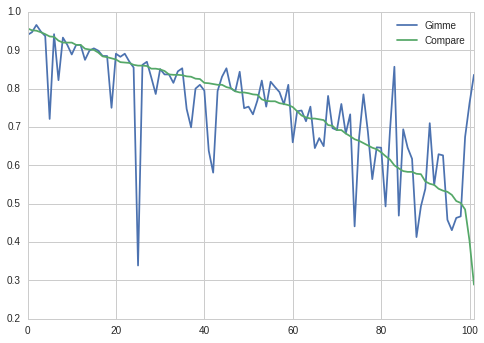

In [116]:
test.plot()

In [96]:
!gimme roc {results_path}/{tf_id}_combined_best.pwm {results_path}/{tf_id}_test.fa {results_path}/{tf_id}_bg.fa

Motif	ROC AUC	MNCP	Enr. at 5% FDR	Max enr.
Posmo_4	0.818	1.750373	13.29	116.50
BioProspector_w6_5	0.784	1.629351	8.16	21.67
GimmeMotifs_2	0.492	0.986362	1.06	6.50
GimmeMotifs_1	0.767	1.675174	11.37	180.50
Posmo_3	0.492	0.986397	1.06	6.50


In [ ]:
tf_list = "cebpb ctcf egr1 elf1 ets1 gata3 hnf4a mafk max mef2a nrf1 pax5 pou2f2 prdm1 sp1 srf tcf3 yy1".split()
gimme_ennergy_frame=pd.DataFrame()
for tf in tf_list:
    tests = pd.read_table("/home/kipkurui/Project/Motif_Assessment/GIMME_ROC/%s/%s.gimme" % (tf.capitalize(),tf.capitalize()), index_col="Motif")
    b = tests.sort_index()[['ROC AUC']]
    raw_score = "/home/kipkurui/Project/Motif_Assessment/PAPER_Assessment_Data/Kibet-F1000Research/ChIP_seq/Results"
    auc_raw = pd.read_table("%s/%s/%s_auc.rawscores" % (raw_score,tf,tf), index_col="Motif")
    auc_raw = auc_raw.sort_index()
    added = auc_raw.T.append(b.T).T
    gimme_energy = added[['energy','ROC AUC']]
    
    #gimme_energy = gimme_energy.corr()
    
    #a = gimme_energy['energy']
    a = gimme_energy.mean().to_frame(name=tf)
    gimme_ennergy_frame = gimme_ennergy_frame.append(a.T)
    
    #sns.clustermap(added.corr(method="spearman"), annot=True)

In [461]:
#3.5.3.0.3, 1.2.4.1.12
chipseq.remove("3.5.3.0.3")

### Reomove this code below

We refer to these as mainmodules for now, but teh intebtion is to tranfer them to theri respective location to allow for further analsysis. 

In [ ]:
def gomeroccupancyscore(pwm_dictionary, seq):
    """
    Takes as input a PWM dictionary, and a sequences and
    computes the gomer score
    """
    if "N" in seq:
        return 0
    else:
        pwm_length = len(pwm_dictionary["A"])
        gomer_occupancy = 1
        area_pwm_rc = rc_pwm(pwm_dictionary, pwm_length)
        for i in range(pwm_length - 1, 1, -1):
            prod_gomer = 1
            prod_gomer_rc = 1
            for j in range(pwm_length):
                if j <= i:
                    prod_gomer *= 0.25
                    prod_gomer_rc *= 0.25
                elif (j + i) > len(seq)-1:
                    prod_gomer *= 0.25
                    prod_gomer_rc *= 0.25
                else:
                    # print "got to else"
                    s = seq[j + i]
                    prod_gomer *= pwm_dictionary[s][j]
                    prod_gomer_rc *= area_pwm_rc[s][j]
            gomer_occupancy *= (1 - prod_gomer) * (1 - prod_gomer_rc)
        for i in range(len(seq) - 1):
            prod_gomer = 1
            prod_gomer_rc = 1
            for j in range(pwm_length - 1):
                if (j + i) >= len(seq)-1:
                    prod_gomer *= 0.25
                    prod_gomer_rc *= 0.25
                else:
                    prod_gomer *= pwm_dictionary[seq[j + i]][j]
                    prod_gomer_rc *= area_pwm_rc[seq[j + i]][j]
            gomer_occupancy *= (1 - prod_gomer) * (1 - prod_gomer_rc)
        gomer_occupancy = 1 - gomer_occupancy
        return gomer_occupancy

from math import exp

def energyscore(pwm_dictionary, seq):
    """
    Score sequences using the beeml energy scoring approach.

    Borrowed greatly from the work of Zhao and Stormo

    P(Si)=1/(1+e^Ei-u)

    Ei=sumsum(Si(b,k)e(b,k))

    Previous approaches seem to be using the the minimum sum of the
    energy contribution of each of the bases of a specific region.

    This is currently showing some promise but further testing is
    needed to ensure that I have a robust algorithm.
    """
    if "N" in seq:
        return 0
    else:
        energy_list = []
        pwm_length = len(pwm_dictionary["A"])
        pwm_dictionary_rc = rc_pwm(pwm_dictionary, pwm_length)
        for i in range(len(seq) - 1):
            energy = 0
            energy_rc = 0
            for j in range(pwm_length - 1):
                if (j + i) >= len(seq):
                    energy += 0.25
                    energy_rc += 0.25
                else:
                    energy += pwm_dictionary[seq[j + i]][j]
                    energy_rc += pwm_dictionary_rc[seq[j + i]][j]

                energy_list.append(1 / (1 + (exp(energy))))
                energy_list.append(1 / (1 + (exp(energy_rc))))
        energy_score = min(energy_list)
        return energy_score

    
def get_from_cluster_key(cluster_key, top_10):
    """
    Given top ten motifs based on 
    """
    extract =[]
    for i in top_10:
        with open(cluster_key) as cluster:
            for line in cluster:
                if i in line:
                    lines = line.split()
                    if len(lines)> 1:
                        adds = lines[1].split(",")
                        extract.extend(adds)
                    else:
                        extract.extend(lines)
    return extract

def extract_pfm(pfm_in, pfm_out, extract):
    with open(pfm_out, "w") as pfm_o:
        stat = 0
        for mot in extract:
            with open(pfm_in) as pfm_i:
                for line in pfm_i:
                    if ">" in line:
                        if mot == line.strip().split(">")[1]:
                            pfm_o.write(line)
                            #print line,
                            stat = 1
                            continue
                    if ">" in line:
                        if mot in line:
                            continue
                        else:
                            stat = 0
                    if stat == 1:
                        pfm_o.write(line)

def extract_meme(meme_in, motif, meme_out, raw_dict):
    with open(meme_in) as f1:
        with open(meme_out, "a") as out_meme:
            lines = f1.readlines()
            for i, line in enumerate(lines):
                head = line.split()
                if motif in line and motif == head[1]:
                    k = i
                    out_meme.write("\n"+lines[i].strip()+"_"+raw_dict[motif]+"\n\n")
                    if "log-odds" in lines[i+1]:
                        odds = lines[k+2].split()
                        for j in range(2, (int(odds[5])+3)*2):
                            out_meme.write(lines[i+j]),
                    elif "letter-probability" in lines[i+2]:
                        out_meme.write(lines[i+2])
                        odds = lines[k+2].split()
                        for j in range(0, (int(odds[5]))):
                            out_meme.write(lines[i+3+j])
                    else:
                        pass


def get_dict(raw_file):
    from collections import OrderedDict
    raw_dict = OrderedDict()
    with open(raw_file) as raw_in:
        for line in raw_in:
            raw_dict[line.split()[0]] = line.split()[-1]
    return raw_dict


def extract_scored_meme(meme_in, out_meme, raw_dict):
    meme_head = """MEME version 4.4\n\nALPHABET= ACGT\n\nstrands: + -\n
Background letter frequencies (from uniform background):
A 0.25000 C 0.25000 G 0.25000 T 0.25000\n"""
    with open(out_meme, "w") as meme_out:
        meme_out.write(meme_head)
    for key in raw_dict.iterkeys():
        extract_meme(meme_in, key, out_meme, raw_dict)

def extract_meme_list(meme_in, out_meme, mot_list):
    """
    Use this to extract motifs in a given list from the main file. This differes
    from extract_scored since it does not add the scores of the motifs to the 
    meme header name
    """
    meme_head = """MEME version 4.4\n\nALPHABET= ACGT\n\nstrands: + -\n
Background letter frequencies (from uniform background):
A 0.25000 C 0.25000 G 0.25000 T 0.25000\n"""
    with open(out_meme, "w") as meme_out:
        meme_out.write(meme_head)
    for mot in mot_list:
        extract_meme_clean(meme_in, mot, out_meme)

def extract_meme_clean(meme_in, motif, meme_out):
    """
    Get the given motif from file
    """
    with open(meme_in) as f1:
        with open(meme_out, "a") as out_meme:
            lines = f1.readlines()
            for i, line in enumerate(lines):
                head = line.split()
                if motif in line and motif == head[1]:
                    k = i
                    out_meme.write("\n"+lines[i].strip()+"\n\n")
                    if "log-odds" in lines[i+1]:
                        odds = lines[k+2].split()
                        for j in range(2, (int(odds[5])+3)*2):
                            out_meme.write(lines[i+j]),
                    elif "letter-probability" in lines[i+2]:
                        out_meme.write(lines[i+2])
                        odds = lines[k+2].split()
                        for j in range(0, (int(odds[5]))):
                            out_meme.write(lines[i+3+j])
                    else:
                        pass

def meme2gimme(meme, gimme):
    with open(meme) as motif:
        with open(gimme, 'w') as gmotif:
            for line in motif:
                if line.startswith("MOTIF"):
                    if len(line.split(" ")) > 2:
                        gmotif.write(">"+line.split(" ")[1]+"\n")
                    else:
                        gmotif.write(">"+line.split(" ")[1])
                elif line.startswith('letter-probability'):
                    continue
                elif line.startswith('  '):
                    a = line.split()
                    if len(a)>0:
                        gmotif.write(a[0]+'\t'+a[1]+'\t'+a[2]+'\t'+a[3]+'\n')
                    else:
                        continue
                elif line.startswith("\n"):
                    continue
                else:
                    continue

def gimme2meme(gimme_in,meme_out):

    As=[]
    Cs=[]
    Gs=[]
    Ts=[]
    motifname="motifname"
    with open(meme_out, "w") as f3:
        f3.write("""MEME version 4.4\n\nALPHABET= ACGT\n\n
strands: + -\n\nBackground letter frequencies (from uniform background):\nA 0.25000 C 0.25000 G 0.25000 T 0.25000\n
        """)
        with open(gimme_in) as f1:
            for line in f1:
                if line.startswith(">"):
                    if len(As)>0:
                        motif=("\nMOTIF %s\n\n"% (motifname))
                        f3.write(motif)
                        header=("letter-probability matrix: alength= 4 w= %s nsites= 20 E= 0\n" % (str(len(As)))) 
                        f3.write(header)
                        for i in range(0,len(As)):
                            out=("  %.6f\t  %.6f\t  %.6f\t  %.6f\t\n" %(float(As[i]),float(Cs[i]),float(Gs[i]),float(Ts[i])))
                            f3.write(out)
                    else:
                        f3.write("\n")
                    As=[]
                    Cs=[]
                    Gs=[]
                    Ts=[]
                    motifname=line.strip().split(">")[1]
                else:
                    As+=[line.strip().split()[0]]
                    Cs+=[line.strip().split()[1]]
                    Gs+=[line.strip().split()[2]]
                    Ts+=[line.strip().split()[3]]
        motif=("\nMOTIF %s\n\n"% (motifname))
        f3.write(motif)
        header=("letter-probability matrix: alength= 4 w= %s nsites= 20 E= 0\n" % (str(len(As)))) 
        f3.write(header)
        for i in range(0,len(As)):
            out=("  %.6f\t  %.6f\t  %.6f\t  %.6f\t\n" %(float(As[i]),float(Cs[i]),float(Gs[i]),float(Ts[i])))
            f3.write(out)



def gimmepfm2meme(pfm_in, meme_out):
    
    import sys
    As=[]
    Cs=[]
    Gs=[]
    Ts=[]
    in_file = pfm_in

    motifname="motifname"
    with open(meme_out, "w") as f3:
        f3.write("""MEME version 4.4\n\nALPHABET= ACGT\n\n
strands: + -\n\nBackground letter frequencies (from uniform background):\nA 0.25000 C 0.25000 G 0.25000 T 0.25000\n
        """)
        with open(in_file) as f1:
            for line in f1:
                if line.startswith(">"):
                    if len(As)>0:
                        motif=("\nMOTIF %s\n\n"% (motifname))
                        f3.write(motif)
                        header=("letter-probability matrix: alength= 4 w= %s nsites= 20 E= 0\n" % (str(len(As)))) 
                        f3.write(header)
                        for i in range(0,len(As)):
                            totals = float(As[i])+float(Cs[i])+float(Gs[i])+float(Ts[i])
                            out=("  %.6f\t  %.6f\t  %.6f\t  %.6f\t\n" %
                                 (float(As[i])/totals,float(Cs[i])/totals,float(Gs[i])/totals,float(Ts[i])/totals))
                            f3.write(out)
                    else:
                        f3.write("\n")
                    As=[]
                    Cs=[]
                    Gs=[]
                    Ts=[]
                    motifname=line.strip().split(">")[1]
                else:
                    As+=[line.strip().split()[0]]
                    Cs+=[line.strip().split()[1]]
                    Gs+=[line.strip().split()[2]]
                    Ts+=[line.strip().split()[3]]
            motif=("\nMOTIF %s\n\n"% (motifname))
            f3.write(motif)
            header=("letter-probability matrix: alength= 4 w= %s nsites= 20 E= 0\n" % (str(len(As)))) 
            f3.write(header)
            for i in range(0,len(As)):
                totals = float(As[i])+float(Cs[i])+float(Gs[i])+float(Ts[i])
                out=("  %.6f\t  %.6f\t  %.6f\t  %.6f\t\n" %
                     (float(As[i])/totals,float(Cs[i])/totals,float(Gs[i])/totals,float(Ts[i])/totals))
                f3.write(out)

# Back-up scripts

In [ ]:
newes[4] = newes[2].apply(lambda seq: "http://hgdownload.cse.ucsc.edu/goldenPath/hg19/encodeDCC/wgEncodeAwgTfbsUniform/%s.gz" % seq)

newes.columns = [["Raw_name", "path", "Tf_name", "Download_link"]]

newes.to_csv("./Example_data/Raw_encode.txt", columns=["Tf_name", "Raw_name", "Download_link"], sep="\t", index=None)

for tf_id in chipseq:    
    with open("./Example_data/raw_chipseq.txt") as pbm_chip:
        with open("./Example_data/All_raw_Encode.txt", "a") as chip_out:
            for line in pbm_chip:
                if pbmchip2name[tf_id] in line:
                    down = "http://hgdownload.cse.ucsc.edu/goldenPath/hg19/encodeDCC/wgEncodeAwgTfbsUniform/%s.gz" % line.split()[0]
                    chip_out.write("%s\t%s\n" % (pbmchip2name[tf_id], down))